## Continuación de gradientes en base a modos de PCA
## 4_ delta de vol de canal segun colectividad de modos (histograma)
## 5_ idem, pero recortando los vectores p/ quedarme con los elementos q se corresponden a aminoácidos de las paredes.
## 6_  gráfico de los modos q más varían al hueco

In [33]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [34]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [35]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [36]:
function read_ptraj_modes(file::AbstractString, modes_elements::Int64; norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [37]:
function displaceAA(mod_pdb::Array{MIToS.PDB.PDBResidue,1}, vector1::Array{Float64}, multiplier::Float64)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [38]:
function WeightedHist(in_vec::Array{Float64, 1}, in_bins::Array{Float64, 1}, in_weight::Array{Float64, 1})
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    return out_counts, out_middle
end

WeightedHist (generic function with 1 method)

## 4_ delta de vol de canal segun colectividad de modos (histograma)

### Preparo variables. Leo modos y los vectores gradiente con desplazamiento entre -2 y 2, según frecuencia

In [39]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
pdb_name = "tfo"
filename_pdb_file_original = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/cut_avg_", pdb_name, ".pdb")
pdb_filename = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/bu/cut_avg_mto.pdb")
tfo_pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(tfo_pdb)
    push!(natom_res, length(tfo_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(tfo_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_tfo, evals_tfo = read_ptraj_modes("/home/german/labo/16/hemo/run/tfo/pca/modes_tfo", aa3);
modes_tfo_1 = Array{Float64}(aa3, aa3-6);
modes_tfo__1 = Array{Float64}(aa3, aa3-6);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/tfo/"

# Leo gradientes
in_filename_gdte_corto_nonfreq = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/dd2_NDD_corto_tfo")
in_filename_gdte_portal_nonfreq = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/dd2_NDD_portal_tfo")
in_filename_gdte_largo_nonfreq = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/dd2_NDD_largo_tfo")
in_filename_gdte_whole_nonfreq = string("/home/german/labo/16/hemo/cavities/freq_ana_mode_gradient/vtores/dd2_NDD_whole_tfo")

gdte_corto = readtable(in_filename_gdte_corto_nonfreq)[:delta]
gdte_corto = convert(Array{Float64}, gdte_corto)

gdte_portal = readtable(in_filename_gdte_portal_nonfreq)[:delta]
gdte_portal = convert(Array{Float64}, gdte_portal)

gdte_largo = readtable(in_filename_gdte_largo_nonfreq)[:delta]
gdte_largo = convert(Array{Float64}, gdte_largo)

gdte_whole = readtable(in_filename_gdte_whole_nonfreq)[:delta];
gdte_whole = convert(Array{Float64}, gdte_whole);

### Antes de calcular colectividad le pongo 0.00001 o -0.00001 a los elementos nulos. Así no me da NaN

In [40]:
modes_tfo_1 = Array{Float64}(aa3, aa3-6);
modes_tfo__1 = Array{Float64}(aa3, aa3-6);

# Arreglo el pbma de 0
for i=1:size(modes_tfo)[1]
    for j=1:size(modes_tfo)[2]
        if modes_tfo[i, j] == 0
            modes_tfo_1[i, j] = 0.00001
        else
            modes_tfo_1[i, j] = modes_tfo[i, j]
        end
    end
end
# Arreglo el pbma de 0
for i=1:size(modes_tfo)[1]
    for j=1:size(modes_tfo)[2]
        if modes_tfo[i, j] == 0
            modes_tfo__1[i, j] = -0.00001
        else
            modes_tfo__1[i, j] = modes_tfo[i, j]
        end
    end
end

### Calculo colectividad de c/ modo usando a ecu (4) de SANEJOUAND; Conformational change of proteins arising from normal mode calculations

In [41]:
κ_1 = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_tfo_1, 1), 1)) ./ size(modes_tfo)[1]
κ_1 = reshape(κ_1, size(modes_tfo)[2])

κ__1 = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_tfo__1, 1), 1)) ./ size(modes_tfo)[1]
κ__1 = reshape(κ__1, size(modes_tfo)[2])

# kappa_1 y kappa__1 son iguales. Así q uso una de las 2
κ = κ_1;

### Plotteo

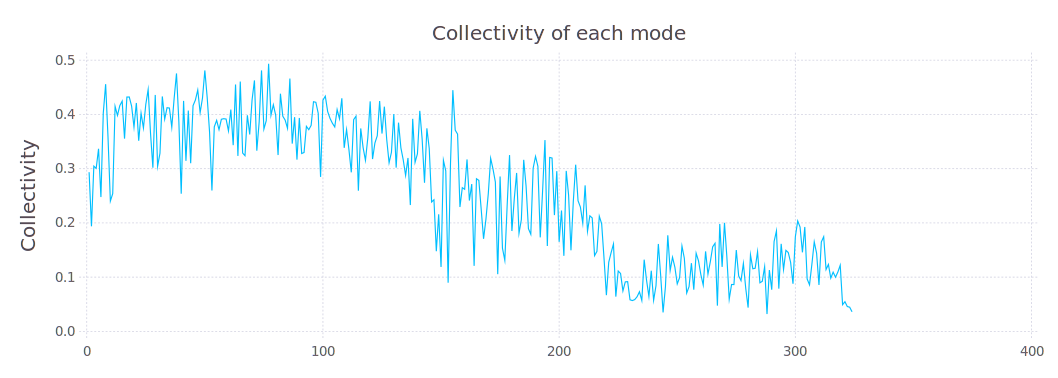

In [42]:
plot(DataFrame(Collectivity=κ), y="Collectivity", Geom.line, 
Guide.title("Collectivity of each mode"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Obtengo histogramas ponderados de los gradientes

In [43]:
bins_corto = collect(0:0.01:0.3)
bins_portal = collect(0:0.01:0.25)
bins_largo = collect(0:0.01:0.2)
bins_whole = collect(0:0.01:0.2)

gdte_corto_his, gdte_corto_bins = WeightedHist(abs(gdte_corto), bins_corto, κ)
df_gdte_corto_his = DataFrame(density = gdte_corto_his, Collectivity = gdte_corto_bins)

gdte_portal_his, gdte_portal_bins = WeightedHist(abs(gdte_portal), bins_portal, κ)
df_gdte_portal_his = DataFrame(density = gdte_portal_his, Collectivity = gdte_portal_bins)

gdte_largo_his, gdte_largo_bins = WeightedHist(abs(gdte_largo), bins_largo, κ)
df_gdte_largo_his = DataFrame(density = gdte_largo_his, Collectivity = gdte_largo_bins)

gdte_whole_his, gdte_whole_bins = WeightedHist(abs(gdte_whole), bins_whole, κ);
df_gdte_whole_his = DataFrame(density = gdte_whole_his, Collectivity = gdte_whole_bins);

### Plotteo

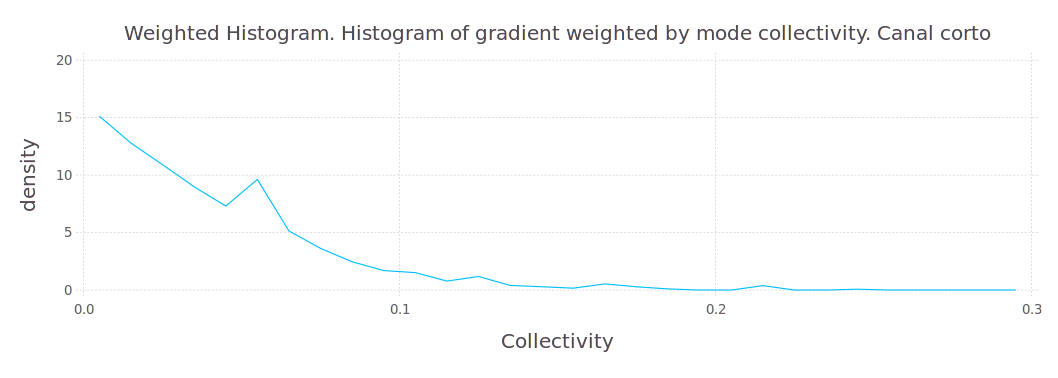

In [44]:
plot(df_gdte_corto_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal corto"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

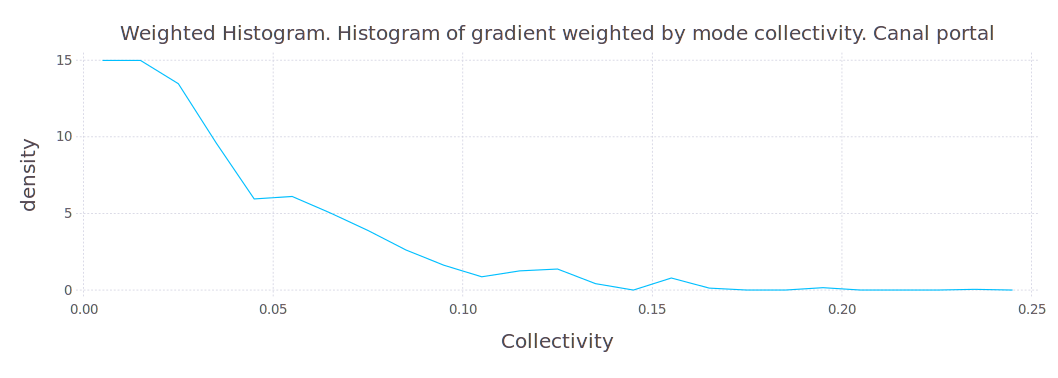

In [45]:
plot(df_gdte_portal_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal portal"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

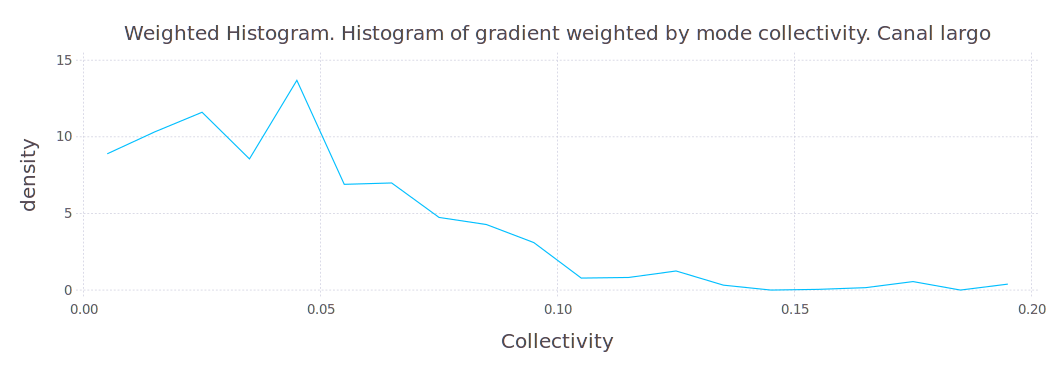

In [46]:
plot(df_gdte_largo_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal largo"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

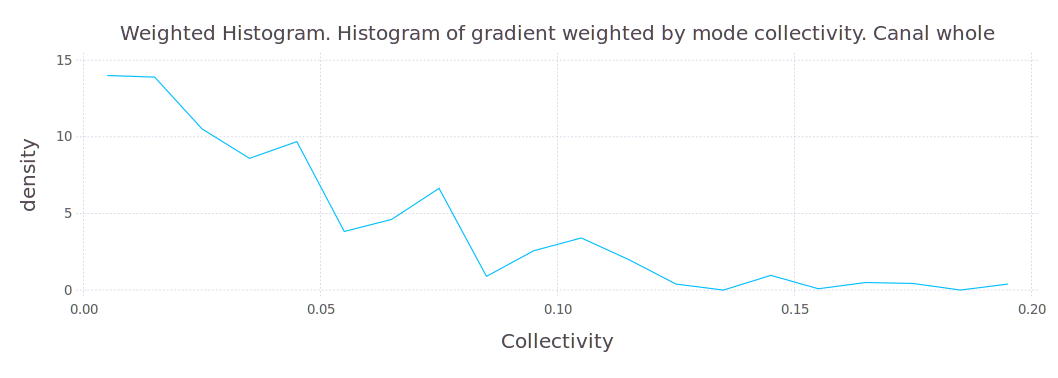

In [47]:
plot(df_gdte_whole_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal whole"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

## 5_ idem, pero recortando los vectores p/ quedarme con los elementos q se corresponden a aminoácidos de las paredes.

### Determino los aminoácidos de las paredes p/ los 4 huecos

In [65]:
# Paso a cartesianas y luego a aminoácidos
aa_gdte_corto = tognm(modes_tfo*gdte_corto)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_corto, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_corto), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_corto = aa_gdte_corto .>= 0.1;
indices_gdte_corto = find(x-> x==true, mask_gdte_corto)
indices_gdte_corto = [ indices_gdte_corto[1:end-3] ; indices_gdte_corto[end-1:end] ]
println(indices_gdte_corto)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_corto = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_corto), 1), 39)
println("\nmode indices:", modeind_gdte_corto)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_tfo_1_corto = modes_tfo_1[modeind_gdte_corto, :];
modes_tfo_1_corto = mapslices(x -> x/norm(x), modes_tfo_1_corto, 1);

[12,13,15,16,17,19,22,23,25,26,31,77,78]

mode indices:[34,35,36,37,38,39,43,44,45,46,47,48,49,50,51,55,56,57,64,65,66,67,68,69,73,74,75,76,77,78,91,92,93,229,230,231,232,233,234]


#### Elijo los aminoácidos: 15 16 17 19 21 22 23 26 73 74. Saqué el '31' pq era cualquie. 73 y 74 estaban luego de 31, pero los dejé pq eran fundamentales.

In [66]:
# Paso a cartesianas y luego a aminoácidos
aa_gdte_portal = tognm(modes_tfo*gdte_portal)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_portal, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_portal), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_portal = aa_gdte_portal .>= 0.1;

indices_gdte_portal = find(x-> x==true, mask_gdte_portal)
indices_gdte_portal = indices_gdte_portal[1:end-2]
println(indices_gdte_portal)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_portal = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_portal), 1), 30)
println("\nmode indices:", modeind_gdte_portal)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_tfo_1_portal = modes_tfo_1[modeind_gdte_portal, :];
modes_tfo_1_portal = mapslices(x -> x/norm(x), modes_tfo_1_portal, 1);

[13,26,27,28,31,34,37,61,64,66]

mode indices:[37,38,39,76,77,78,79,80,81,82,83,84,91,92,93,100,101,102,109,110,111,181,182,183,190,191,192,196,197,198]


#### Elijo los aminoácidos: 25  26 29 30 31 34 38 52 57 60 62 64 66. Estos 2 estaban al final y eran cualquie: 74 102

In [67]:
# Paso a cartesianas y luego a aminoácidos
aa_gdte_largo = tognm(modes_tfo*gdte_largo)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_largo, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_largo), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_largo = aa_gdte_largo .>= 0.1;
indices_gdte_largo = find(x-> x==true, mask_gdte_largo)
println(indices_gdte_largo)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_largo = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_largo), 1), 60)
println("\nmode indices:", modeind_gdte_largo)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_tfo_1_largo = modes_tfo_1[modeind_gdte_largo, :];
modes_tfo_1_largo = mapslices(x -> x/norm(x), modes_tfo_1_largo, 1);

[8,9,12,13,15,16,38,41,42,46,61,70,75,78,82,99,103,106,107,110]

mode indices:[22,23,24,25,26,27,34,35,36,37,38,39,43,44,45,46,47,48,112,113,114,121,122,123,124,125,126,136,137,138,181,182,183,208,209,210,223,224,225,232,233,234,244,245,246,295,296,297,307,308,309,316,317,318,319,320,321,328,329,330]


#### Elijo los aminoácidos: 5 8 9 12 13 38 41 42 52 57 74 75 78 82 95 96 98 99. Conservo a todos.

In [68]:
# Paso a cartesianas y luego a aminoácidos
aa_gdte_whole = tognm(modes_tfo*gdte_whole)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_whole, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_whole), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_whole = aa_gdte_whole .>= 0.1;
indices_gdte_whole = find(x-> x==true, mask_gdte_whole)
println(indices_gdte_whole)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_whole = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_whole), 1), 66)
println("\nmode indices:", modeind_gdte_whole)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_tfo_1_whole = modes_tfo_1[modeind_gdte_whole, :];
modes_tfo_1_whole = mapslices(x -> x/norm(x), modes_tfo_1_whole, 1);

[8,12,13,22,25,26,27,37,38,41,42,61,64,68,70,78,82,99,103,106,107,110]

mode indices:[22,23,24,34,35,36,37,38,39,64,65,66,73,74,75,76,77,78,79,80,81,109,110,111,112,113,114,121,122,123,124,125,126,181,182,183,190,191,192,202,203,204,208,209,210,232,233,234,244,245,246,295,296,297,307,308,309,316,317,318,319,320,321,328,329,330]


#### Elijo a los aminoácidos: 5 8 9 12 15 16 25 26 29 31 34 38 41 42 57 60 62 64 66 71 73 74 75 78 82 95 99 102 106. Conservo a todos.

### Calculo colectividad de c/ modo usando a ecu (4) de SANEJOUAND; Conformational change of proteins arising from normal mode calculations

In [69]:
# CANAL CORTO
κ_corto = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_tfo_1_corto, 1), 1)) ./ size(modes_tfo_1_corto)[1]
κ_corto = reshape(κ_corto, size(modes_tfo_1_corto)[2])

# CANAL PORTAL
κ_portal = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_tfo_1_portal, 1), 1)) ./ size(modes_tfo_1_portal)[1]
κ_portal = reshape(κ_portal, size(modes_tfo_1_portal)[2])

# CANAL LARGO
κ_largo = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_tfo_1_largo, 1), 1)) ./ size(modes_tfo_1_largo)[1]
κ_largo = reshape(κ_largo, size(modes_tfo_1_largo)[2])

# CANAL WHOLE
κ_whole = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_tfo_1_whole, 1), 1)) ./ size(modes_tfo_1_whole)[1]
κ_whole = reshape(κ_whole, size(modes_tfo_1_whole)[2]);

### Plotteo

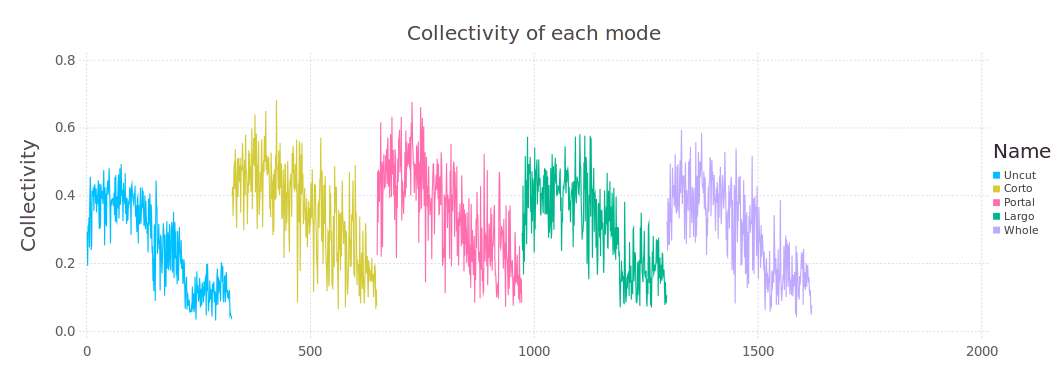

In [70]:
df_κ = DataFrame(Collectivity=[κ; κ_corto; κ_portal; κ_largo; κ_whole],
Name = [ repeat(["Uncut"], inner=[length(κ)]) ; repeat(["Corto"], inner=[length(κ)]);
    repeat(["Portal"], inner=[length(κ)]) ; repeat(["Largo"], inner=[length(κ)]);
    repeat(["Whole"], inner=[length(κ)])],
Index = repeat(collect(1:1:length(κ)), outer=[5]))

plot(df_κ, y="Collectivity", color="Name", Geom.line,
#x="Index",
Guide.title("Collectivity of each mode"),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 15pt))

### Obtengo histogramas ponderados de los gradientes

In [71]:
bins_cut_corto = collect(0:0.01:0.3)
bins_cut_portal = collect(0:0.01:0.25)
bins_cut_largo = collect(0:0.01:0.2)
bins_cut_whole = collect(0:0.01:0.2)

gdte_corto_his_cut, gdte_corto_bins_cut = WeightedHist(abs(gdte_corto), bins_cut_corto, κ_corto)
df_gdte_corto_his_cut = DataFrame(density = gdte_corto_his_cut, Collectivity = gdte_corto_bins_cut)

gdte_portal_his_cut, gdte_portal_bins_cut = WeightedHist(abs(gdte_portal), bins_cut_portal, κ_portal)
df_gdte_portal_his_cut = DataFrame(density = gdte_portal_his_cut, Collectivity = gdte_portal_bins_cut)

gdte_largo_his_cut, gdte_largo_bins_cut = WeightedHist(abs(gdte_largo), bins_cut_largo, κ_largo)
df_gdte_largo_his_cut = DataFrame(density = gdte_largo_his_cut, Collectivity = gdte_largo_bins_cut)

gdte_whole_his_cut, gdte_whole_bins_cut = WeightedHist(abs(gdte_whole), bins_cut_whole, κ_whole)
df_gdte_whole_his_cut = DataFrame(density = gdte_whole_his_cut, Collectivity = gdte_whole_bins_cut);

### Plotteo los nuevos histogramas y los anteriores

### Canalcorto

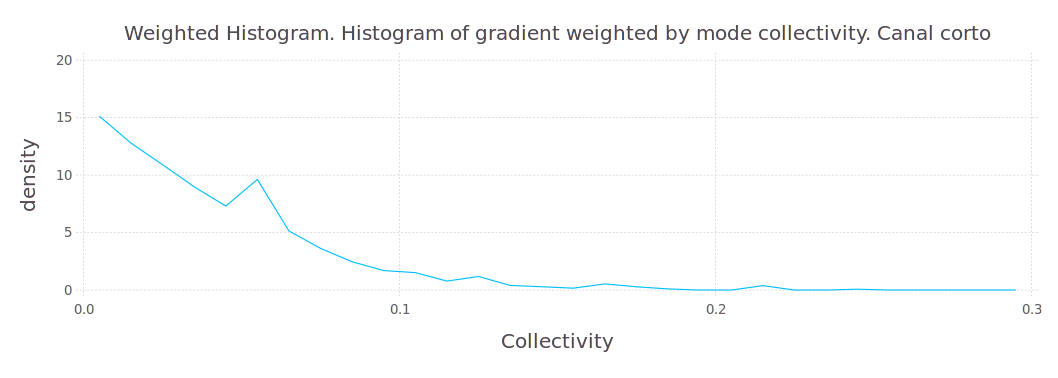

In [72]:
plot(df_gdte_corto_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal corto"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

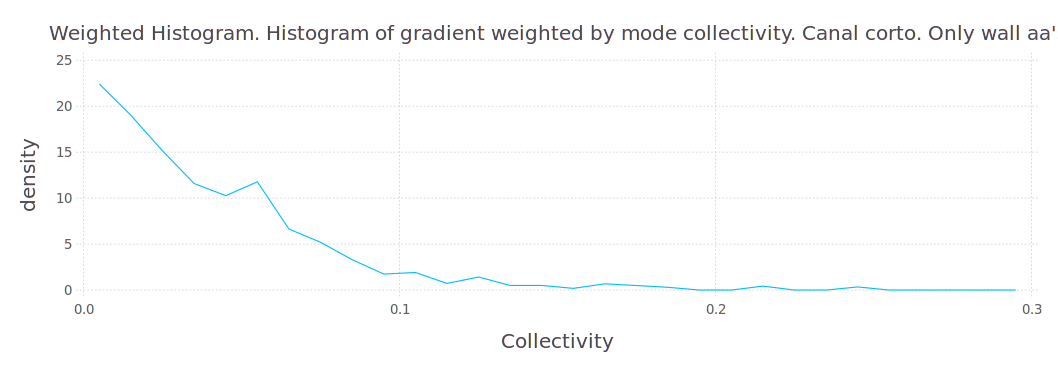

In [73]:
plot(df_gdte_corto_his_cut, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal corto. Only wall aa's"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Canal portal

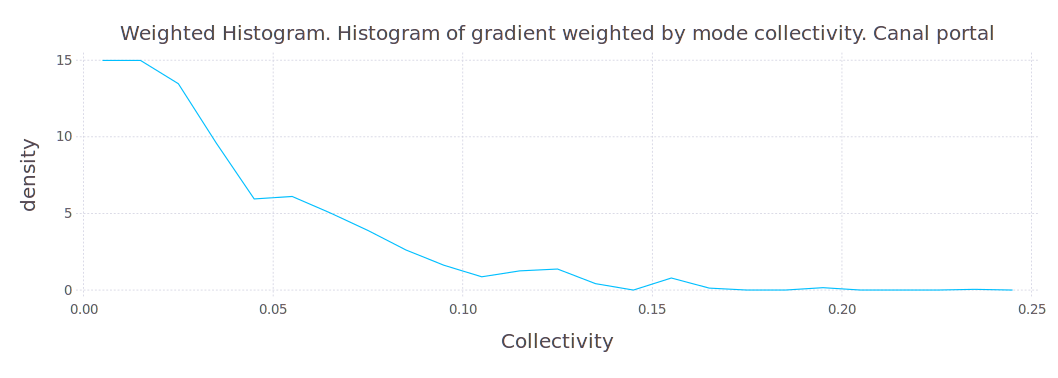

In [74]:
plot(df_gdte_portal_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal portal"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

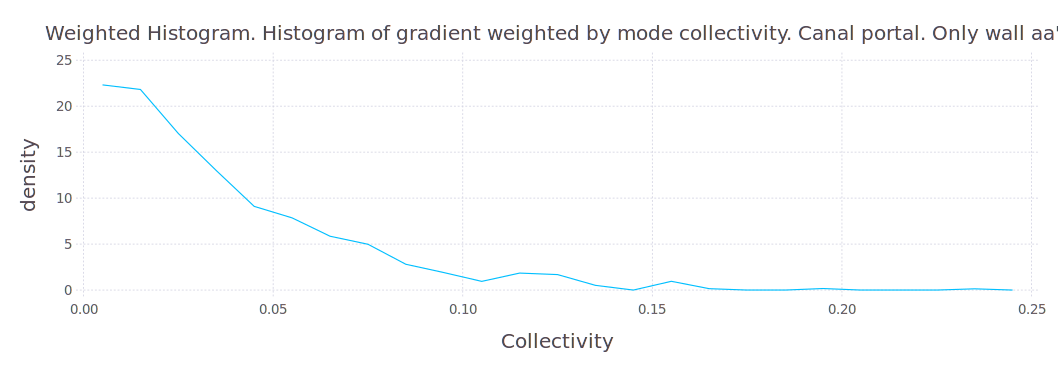

In [75]:
plot(df_gdte_portal_his_cut, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal portal. Only wall aa's"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Canal largo

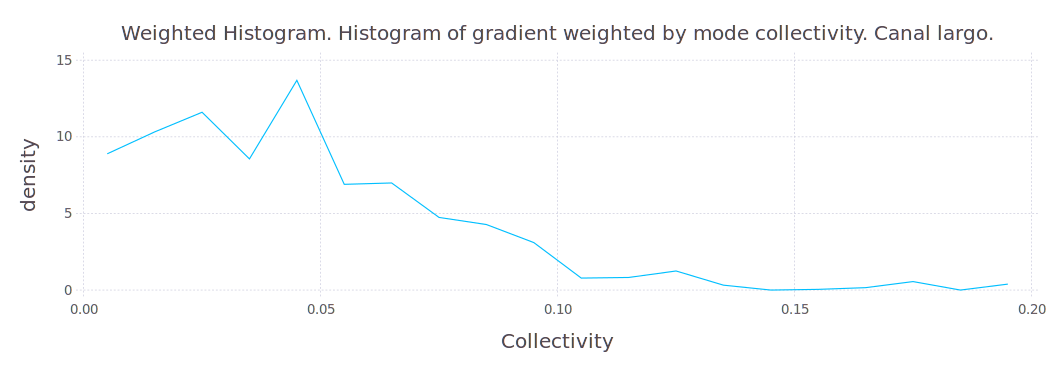

In [76]:
plot(df_gdte_largo_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal largo."), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

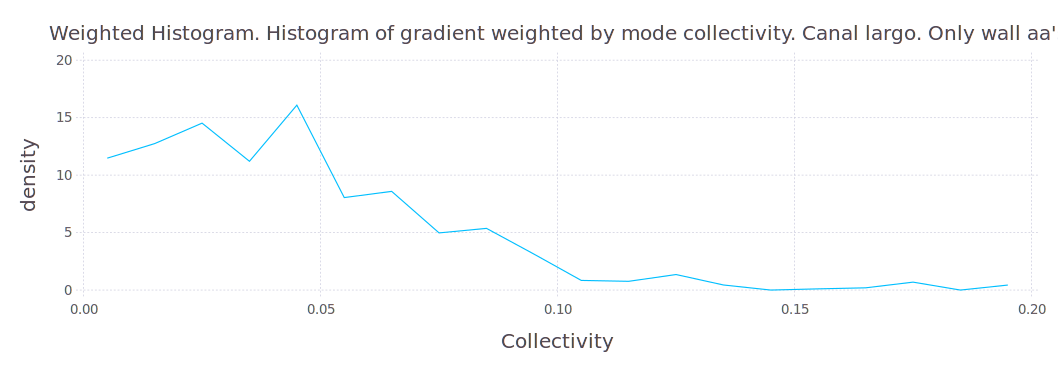

In [77]:
plot(df_gdte_largo_his_cut, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal largo. Only wall aa's"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Canal whole

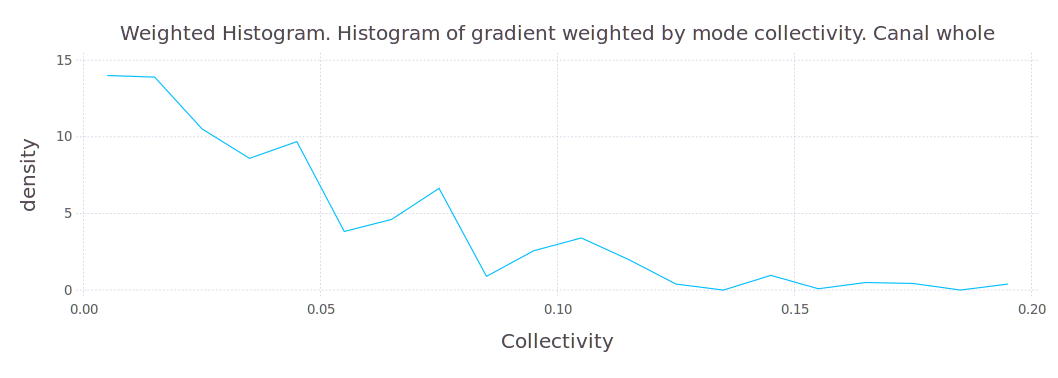

In [78]:
plot(df_gdte_whole_his, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal whole"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

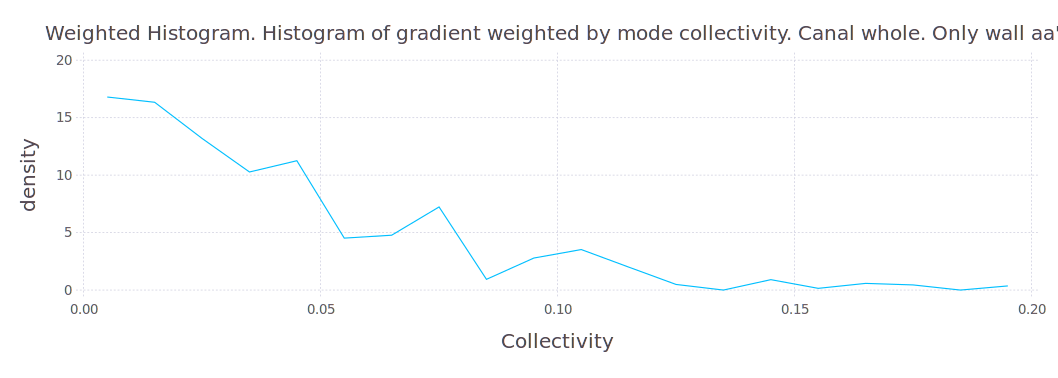

In [79]:
plot(df_gdte_whole_his_cut, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal whole. Only wall aa's"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

## Los histogramas ponderados por colectividad completa y los ponderados por colectividad de aa's de la pared dan iguales. Si hago Histograma sin ponderar también da muy parecido. Ver abajo:

In [80]:
unos = repeat([1.0], inner=[length(κ)])

gdte_corto_his_cut_nonw, gdte_corto_bins_cut_nonw = WeightedHist(abs(gdte_corto), bins_cut_corto, unos)
df_gdte_corto_his_cut_nonw = DataFrame(density = gdte_corto_his_cut_nonw, Collectivity = gdte_corto_bins_cut_nonw)

gdte_portal_his_cut_nonw, gdte_portal_bins_cut_nonw = WeightedHist(abs(gdte_portal), bins_cut_portal, unos)
df_gdte_portal_his_cut_nonw = DataFrame(density = gdte_portal_his_cut_nonw, Collectivity = gdte_portal_bins_cut_nonw)

gdte_largo_his_cut_nonw, gdte_largo_bins_cut_nonw = WeightedHist(abs(gdte_largo), bins_cut_largo, unos)
df_gdte_largo_his_cut_nonw = DataFrame(density = gdte_largo_his_cut_nonw, Collectivity = gdte_largo_bins_cut_nonw)

gdte_whole_his_cut_nonw, gdte_whole_bins_cut_nonw = WeightedHist(abs(gdte_whole), bins_cut_whole, unos)
df_gdte_whole_his_cut_nonw = DataFrame(density = gdte_whole_his_cut_nonw, Collectivity = gdte_whole_bins_cut_nonw);

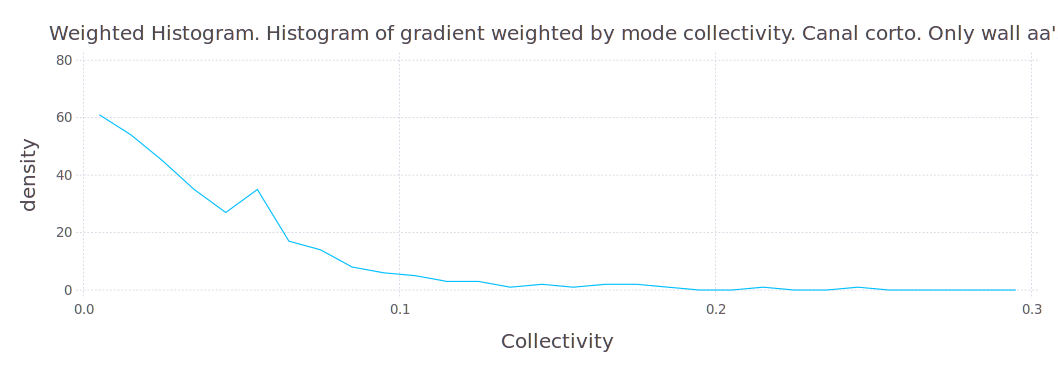

In [81]:
plot(df_gdte_corto_his_cut_nonw, x="Collectivity", y="density", Geom.line,
Guide.title("Weighted Histogram. Histogram of gradient weighted by mode collectivity. Canal corto. Only wall aa's"), 
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))